In [191]:
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import acquire

In [9]:
df = acquire.get_full_sales_data()
df.sale_date = pd.to_datetime(df.sale_date, format = '%a, %d %b %Y %H:%M:%S %Z')


In [10]:
df.set_index('sale_date', inplace = True)

In [14]:
sales = df.sale_amount.resample('d').sum()

In [242]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [243]:
df.tail()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0
790457,2017-12-31,1029399,5790457,0.0,0.0


In [244]:
df.rename(columns={'Month_Invoiced': 'date',
                  'Customer_Id': 'customer_id',
                  'Invoice_Id':'invoice_id',
                  'Subscription_Type':'subscription_type',
                  'Amount':'amount'},
         inplace = True)

In [245]:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace = True)
df.amount.head()

date
2014-01-31     0.0
2014-01-31    10.0
2014-01-31     0.0
2014-01-31     0.0
2014-01-31     5.0
Name: amount, dtype: float64

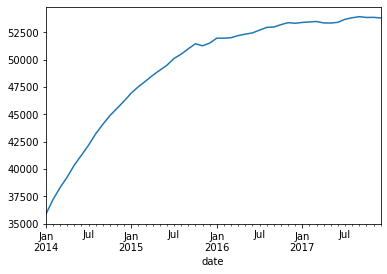

In [246]:
df.amount.resample('m').sum().plot()

In [247]:
m_total = df.amount.resample('m').sum()

In [248]:
df.index.unique()

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [249]:
train_size = int(len(m_total)*.75)
train_size

36

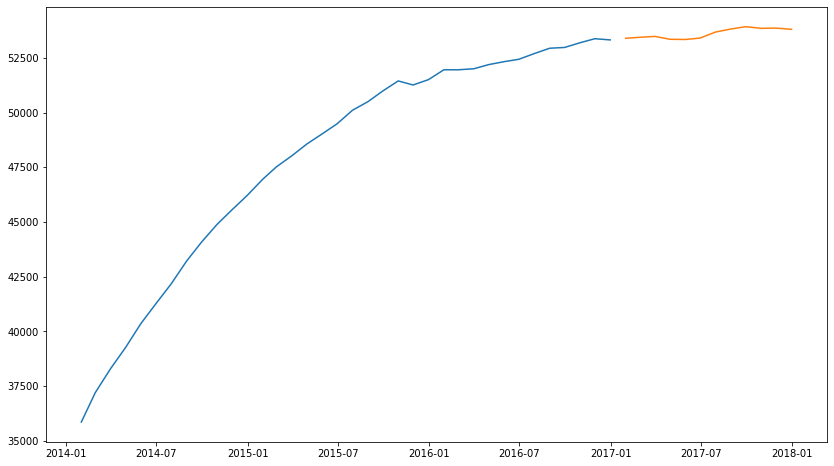

In [250]:
plt.figure(figsize=(14,8))
plt.plot(m_total[:train_size])
plt.plot(m_total[train_size:])

In [251]:
model_strength = pd.DataFrame(columns=['model', 'mse', 'rmse'])

#### Last Value

Text(0.5, 1.0, 'Last Value')

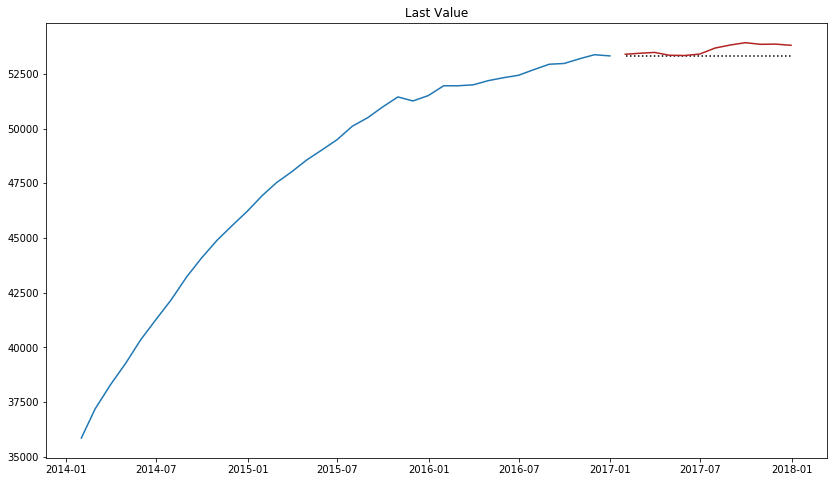

In [254]:
last_value = m_total[train_size-1]
yhat = [last_value] * 12
plt.figure(figsize=(14,8))
plt.plot(m_total[:train_size])
plt.plot(m_total[train_size:], color = 'firebrick')
plt.hlines(last_value, xmin = '2017-02', xmax='2018-01', linestyles=':')
plt.title('Last Value')

In [255]:
mse = mean_squared_error(m_total[train_size:], yhat)
rmse = mse**.5
model_strength = model_strength.append({'model':'last_value', 'mse':mse, 'rmse':rmse}, ignore_index= True)

Text(0.5, 1.0, 'Simple Average')

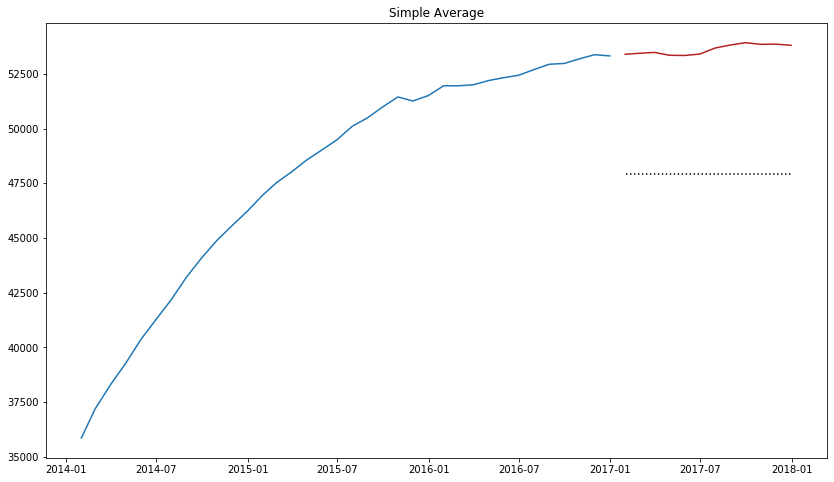

In [256]:
simple_average = m_total[:train_size].mean()
yhat = [simple_average] * 12
plt.figure(figsize=(14,8))
plt.plot(m_total[:train_size])
plt.plot(m_total[train_size:], color = 'firebrick')
plt.hlines(simple_average, xmin = '2017-02', xmax='2018-01', linestyles=':')
plt.title('Simple Average')

In [257]:
mse = mean_squared_error(m_total[train_size:], yhat)
rmse = mse**.5
model_strength = model_strength.append({'model':'mean', 'mse':mse, 'rmse':rmse}, ignore_index= True)

Text(0.5, 1.0, 'Moving Average')

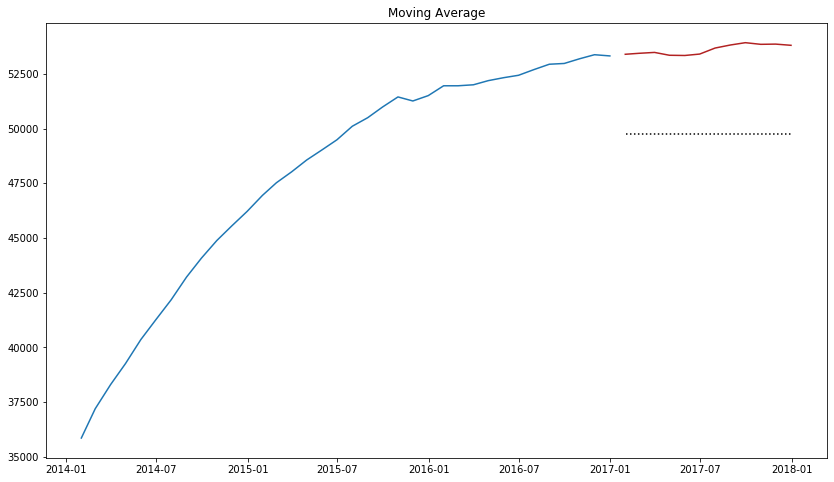

In [258]:
moving_average = m_total[:train_size].rolling(30).mean()[-1]
yhat = [moving_average] * 12
plt.figure(figsize=(14,8))
plt.plot(m_total[:train_size])
plt.plot(m_total[train_size:], color = 'firebrick')
plt.hlines(moving_average, xmin = '2017-02', xmax='2018-01', linestyles=':')
plt.title('Moving Average')

In [259]:
mse = mean_squared_error(m_total[train_size:], yhat)
rmse = mse**.5
model_strength = model_strength.append({'model':'moving_mean', 'mse':mse, 'rmse':rmse}, ignore_index= True)

Text(0.5, 1.0, 'Linear Approximation')

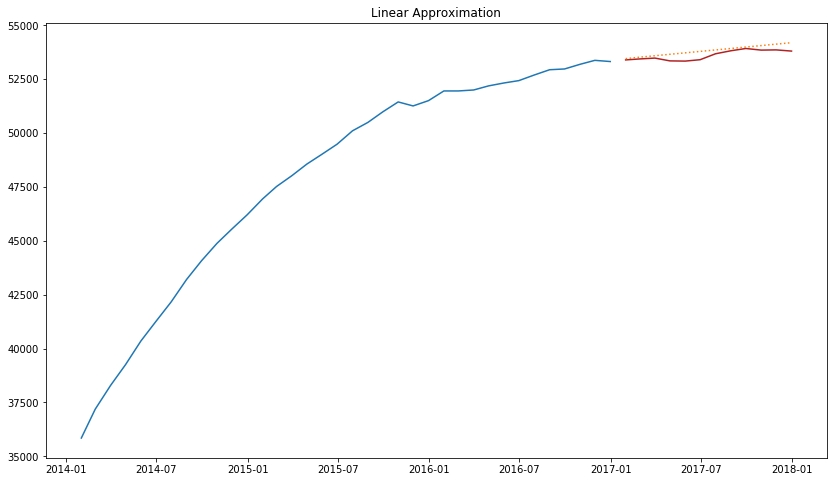

In [260]:
lin_h = Holt(m_total[:train_size]).fit()
yhat = lin_h.forecast(m_total[train_size:].shape[0])
plt.figure(figsize=(14,8))
plt.plot(m_total[:train_size])
plt.plot(m_total[train_size:], color = 'firebrick')
plt.plot(yhat, ls = ':')
plt.title('Linear Approximation')

In [261]:
mse = mean_squared_error(m_total[train_size:], yhat)
rmse = mse**.5
model_strength = model_strength.append({'model':'linear_holt', 'mse':mse, 'rmse':rmse}, ignore_index= True)

Text(0.5, 1.0, 'Exponential Approx')

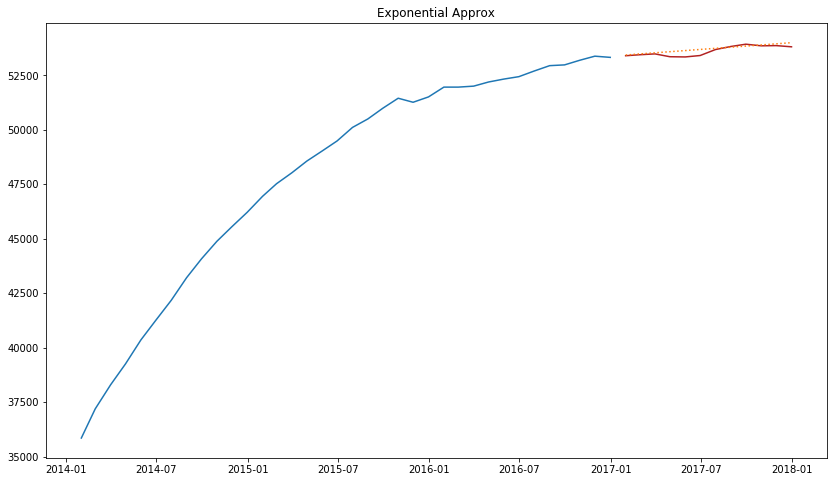

In [262]:
exp_h = Holt(m_total[:train_size], exponential=True).fit()
yhat = exp_h.forecast(m_total[train_size:].shape[0])
plt.figure(figsize=(14,8))
plt.plot(m_total[:train_size])
plt.plot(m_total[train_size:], color = 'firebrick')
plt.plot(yhat, ls = ':')
plt.title('Exponential Approx')

In [263]:
mse = mean_squared_error(m_total[train_size:], yhat)
rmse = mse**.5
model_strength = model_strength.append({'model':'exponential_holt', 'mse':mse, 'rmse':rmse}, ignore_index= True)

In [264]:
model_strength

,model,mse,rmse
0,last_value,1.339583e+05,366.003188
1,mean,3.249092e+07,5700.080652
2,moving_mean,1.489016e+07,3858.776792
3,linear_holt,6.045253e+04,245.870952
4,exponential_holt,2.307297e+04,151.897898
